# EDA (Exploratory Data Analysis) of Pre Processed Data

## 1. Objective
The objective of this notebook is to explore the pre processed data, which are temperature logs with only the sensors that the board is able to read.

### 1.1 Why this matter?
Feature engineering is the process of creating information that will simplify machine learning models to understand what the data is about and thus . For doing so, it's relevant to understand the data at hand, thus facilitating the feature engineering in the future and also understanding possible unseen correlations on the data.

### 1.2 What is the output of this notebook?
This notebook will generate many figures and many textual insights about the temperature logs of our products looks like. 
For example:
- It's clear that a damper in failure will cause the temperature of the compartment to not cycle, probably keeping the compartment very cold or very warm. But how does the temperature chart of such case looks like? How much different is that failure from the conventional steady state of the product?
- The temperature readings of a pulldown routine is very different from a defrost routine, which is also different in the end from defrost routine. But how different are those cycles?

### 1.3 Key Takeaway and actions


ATTENTION: All the below discussion are specific for Torino project products, it's likely that different products will need different assumptions from the ones presented and discussed on this notebook

***
## 2. Setup

Run the below code to import all the necessary libraries and data to run the following codes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection, LineCollection

import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

from src.RefriPlot import *
from src.RefriDataHelper import *

DEFAULT_COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] #Proposed colors, in case temp is not plotted


#Allows generated charts to be interactive
%matplotlib widget

#Read preprocessed CSVs
csv_files = RefriDataHelper_ReadParsedLogs()

#Store the name of the temp columns for further calculations
TEMP_COL_NAMES = list(csv_files.values())[0].columns[2:]

#Print amount of logs
len(csv_files)

384

***
## 3. Basic Temperature Plots

### 3.1 Normal logs
Picking a normal random log from the pre-processed ones we can observe how a typical temperature log looks like.

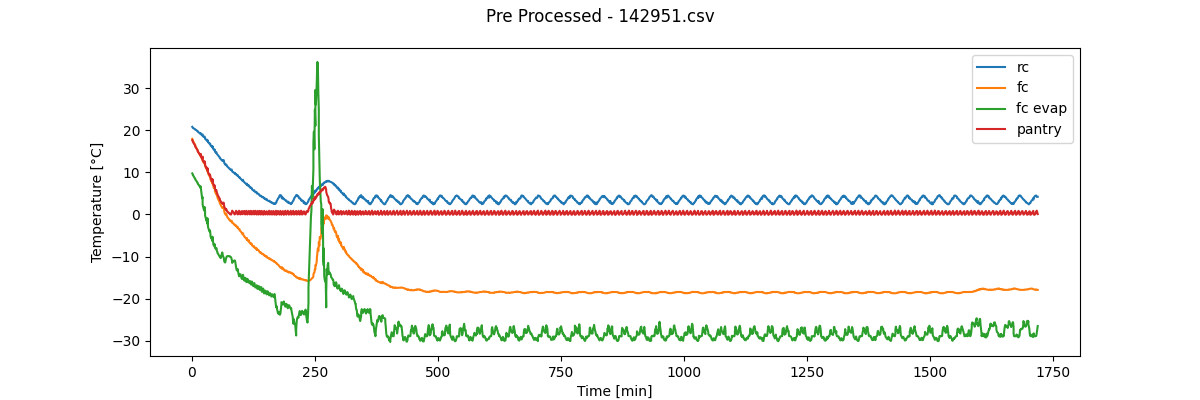

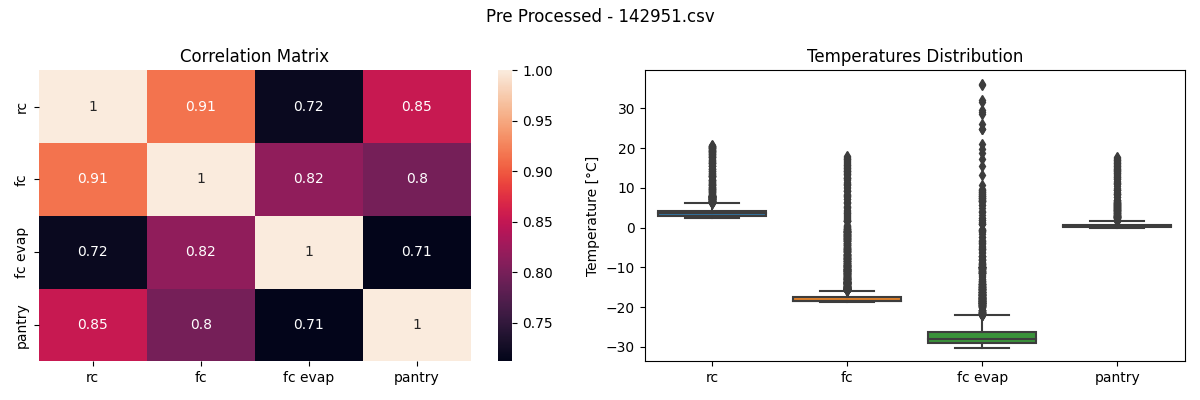

In [2]:
#Pick a know "normal" log
log_name = "Pre Processed - 142951.csv"
log_data = csv_files[log_name]
RefriPlot_PlotTemperature(log_data,log_name)
RefriPlot_PlotCorrelationAndBoxPlot(log_data,log_name)

As you probably observed also on the two lower charts, it was also plotted a correlation matrix as well as the distribution of each sensor.

From the **Correlation Matrix**:
- It's interesting to obser that we have very correlation trougouht all the sensors among themselvs, but specially between RC and FC
- Observing such good correlations could indicate easier machine learning models convergence in the future, as sensors are tightly related to each other

From the **Temperatures Distribution** (box plot):
- It's possible to observe that each sensor has a very narrow distribution with many outliers, represented by the dots
- We can suppose that the large amount of outliers are not outliers per se, as we cannot observe outliers on the main chart. Those dots are actually the values obtained from the pulldown phase of the cooling test (represented by the first 200minutes) as well as the defrost routine (big spike on temperatures around 250min)

With this in mind, this seems to indicate that actually the data distribution seems to be very different among the different "states of the product"

By separating the main chart on 3 separate states, pulldown, defrost and steady, we can repeat the plots to observe their values:


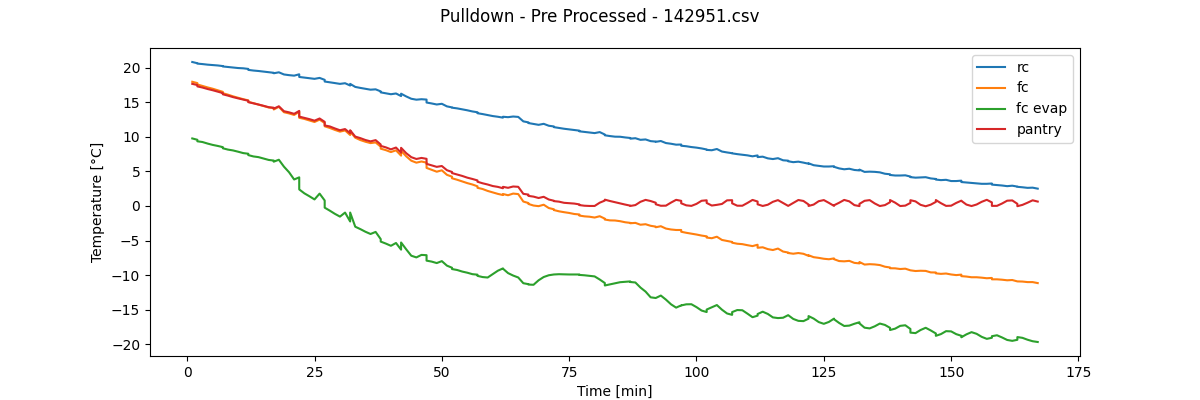

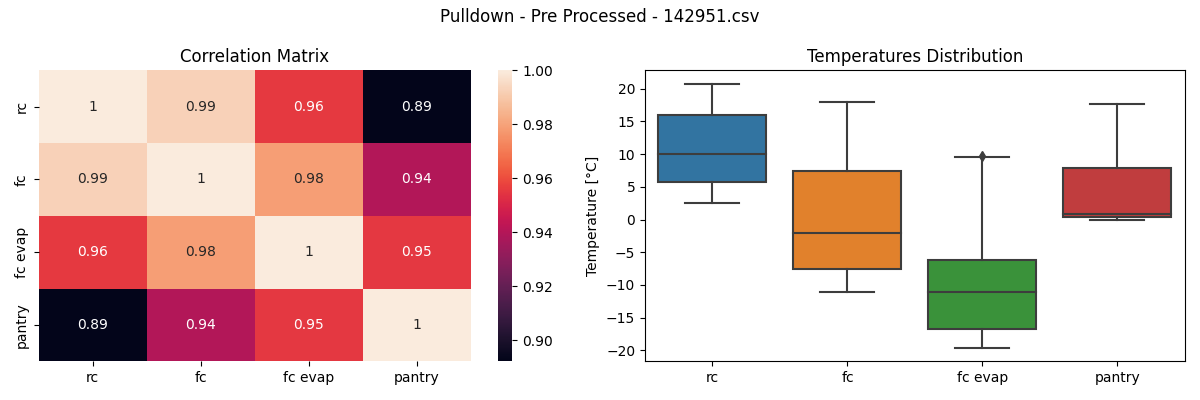

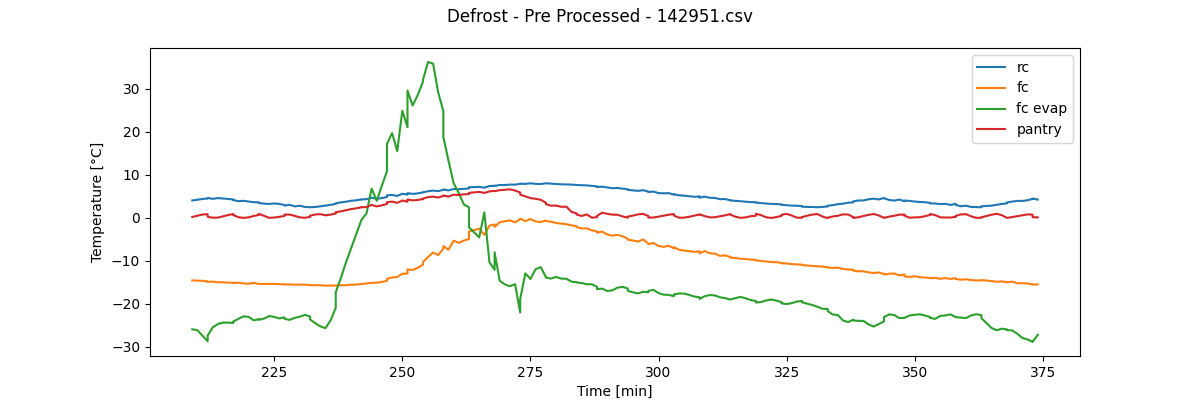

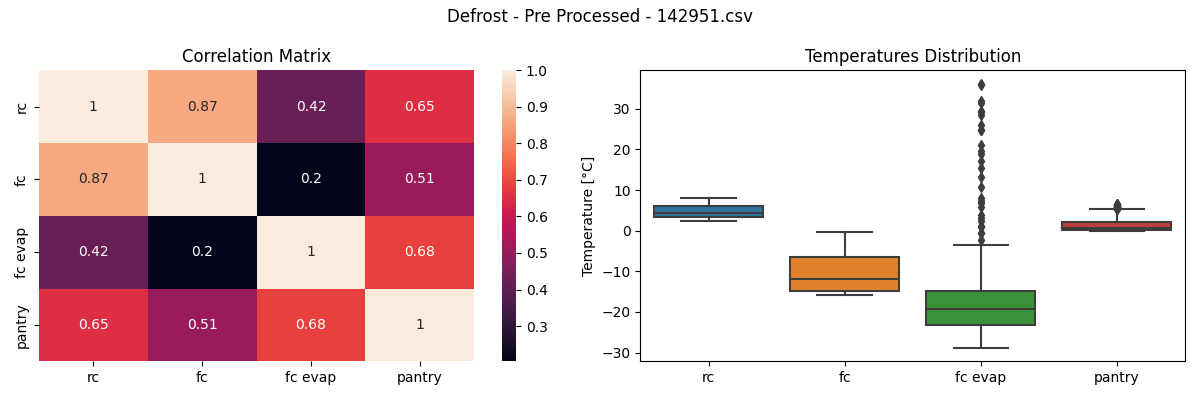

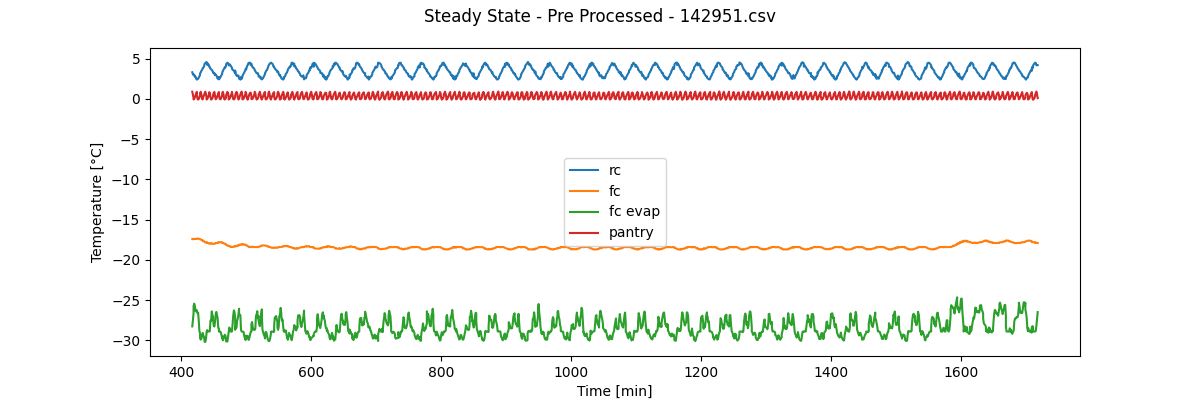

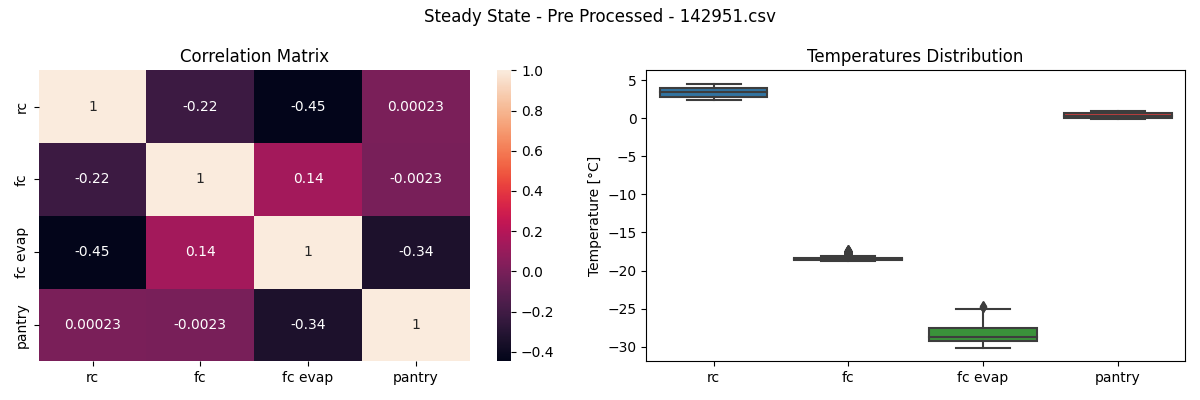

In [3]:
#Separating the initial log into sub regions of the different states of the product
pulldown_log_data = log_data.iloc[:200]
defrost_log_data = log_data.iloc[250:450]
steady_state_log_data = log_data.iloc[500:]

RefriPlot_PlotTemperature(pulldown_log_data,"Pulldown - " + log_name)
RefriPlot_PlotCorrelationAndBoxPlot(pulldown_log_data,"Pulldown - " + log_name)

RefriPlot_PlotTemperature(defrost_log_data,"Defrost - " + log_name)
RefriPlot_PlotCorrelationAndBoxPlot(defrost_log_data,"Defrost - " + log_name)

RefriPlot_PlotTemperature(steady_state_log_data,"Steady State - " + log_name)
RefriPlot_PlotCorrelationAndBoxPlot(steady_state_log_data,"Steady State - " + log_name)

After ploting those 3 different states of the same product, it was clear to observe how much variation on the data we can have even on the same product but with different states.

This is a very important point because, depending on how we approach machine learning models, depending on the time that we get the data, if the model is not properly trained, we can get very different results as the data is very different.

About **pulldown**:
- During Pulldown routine, there was a very high correlation among ALL the sensors. That is explainable, since in Torino`s pulldown routine, all compartments are trying to reach their setpoint as fast as possible, thus they are all reducing their speed very drastically. So they all seem to reduce a similar amount of °C every minute, thus having a high correlation
- Also during pulldown, the distribution was very high and no outlier. Also intuitive, since during most of the time, each sensor has very different values between AMBIENT_TEMPERATURE (initial temperature of around 20°C) up to each compartment setpoints

About **defrost**:
- It's interesting and not very clear why there is a high correlation between pantry, RC and FC Evap. I was expecting quite the opposite, of having a high correlation of FC Evap with FC sensor, since the heating system is actually located on the FC compartment. So even that on Torino we're closing the RC and Pantry damper on the defrost, it seems that the defrost has a high impact on RC and Pantry compartment. Here is one case where we woul probably need to discuss with a cooling engineer. OR Evaluate another log, since this could be a bad log or just serendipity
- As expected, FC Evap shows defrost temperatures as outliers, since the time that the heater is ON is very short in comparisons to the rest of the data, so the very high and fast temperatures are considered as outliers
- It's interesting to observe that defrost impacted FC compartment but only after a delay, where the FC seems to start heating up 10min after defrost started. That is in interesting point because it's some useful information that is not caught by correlation. It will be disscussed later on

About **steady state**:
- This is the ideal state of a product, which hopefully is the one that is running in most cases at costumer's house
- To me the most intersting chart, since it seems to show absolutely no correlation. Which maybe make sense, since at least on this log, the steady state mas not having any compartment being in sync. But here might come drastic differences between different products, since some products actually take advantage and try to synch RC and FC Cooling cycles for example
- As expected, the distribution is very thight and controlled, since we're in the steady state.
- FC Temperature seems to be way too tight, where we don't even seem to be cycling between Cut_in and Cut_off, which is what we do in most cases, like we can observe for RC and Pantry. That is also not very clear to me why. Maybe that was intended by the cooling engineers, to keep a steady comrpessor speed always around -18°C. Or again is just a bad sample log.


The main objective of all this analysis anyway is not to take any assumptions now, since this is only data from a single log. It was mostly to discuss how in the same log there can be very different data distribution

### 3.2 Door Opening logs

Below we're now going to analyze one log that was observed to be very deviant from the usual (it was considered as unusual by some machine learning methods that will be discussed later):

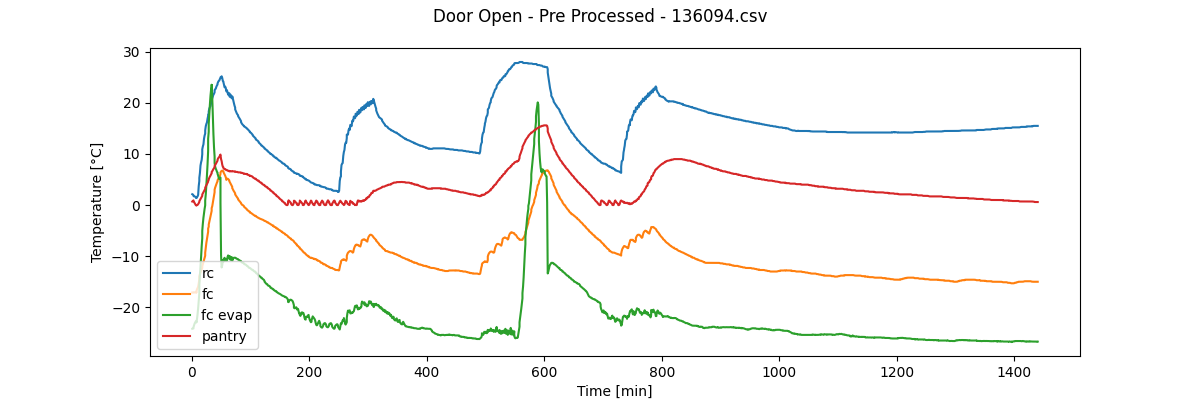

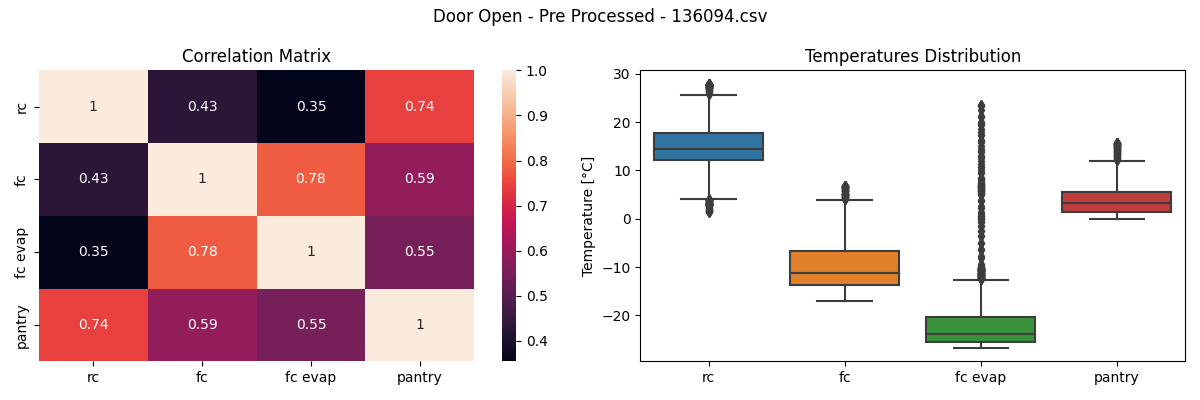

In [4]:
#Pick another know log that contains Door Openings
door_open_log_name = "Pre Processed - 136094.csv"
door_open_log_data = csv_files[door_open_log_name]

RefriPlot_PlotTemperature(door_open_log_data,"Door Open - " + door_open_log_name)
RefriPlot_PlotCorrelationAndBoxPlot(door_open_log_data,"Door Open - " + door_open_log_name)

After discussing with cooling engineers, it was found out that this log is about **door openings test**, which is one of the tests done by the cooling team to observe how the product will react trough different humidity and hot air going inside the product.

It's also interesting to observe that this log had 2 defrosts. The reason for that is because the defrost routine is adaptive, in the sense that it runs more when there are door interactions with the product. According to cooling engineers, this is needed because door opening cause too much humidity to accumulate on the evaporator, which will later on cause too much ice to acumulate around the evaportor as well.

Similar to pulldown, the temperatures of compartments rise and decrease together as the product is trying to cool down really fast, thus causing high correlations between the sensors.

The distribution shows outliers on every sensor, caused by the door openings.

This is a **VERY important point to pay attention to, since door openings can also confound models between what is a fault or not, as we can see that the data also changes a lot. And is even more drastic than the other states discussed previously because it's something that we cannot control and can really change a lot depending on each costumer usage**. This could indicate that it might be necessary to use "door state" information on the models to improve their accuracy.

### 3.3 Faulty logs

Below is one log that was manually observed as faulty with Damper Stuck Open

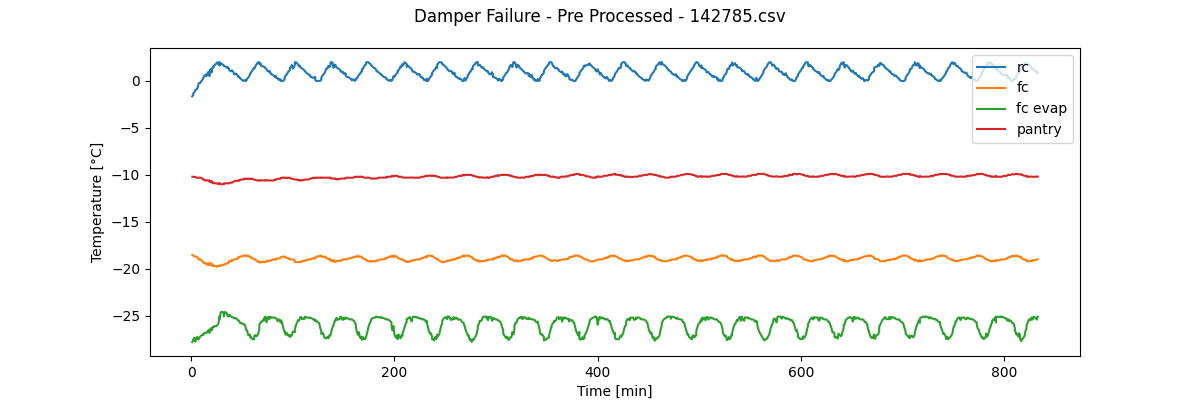

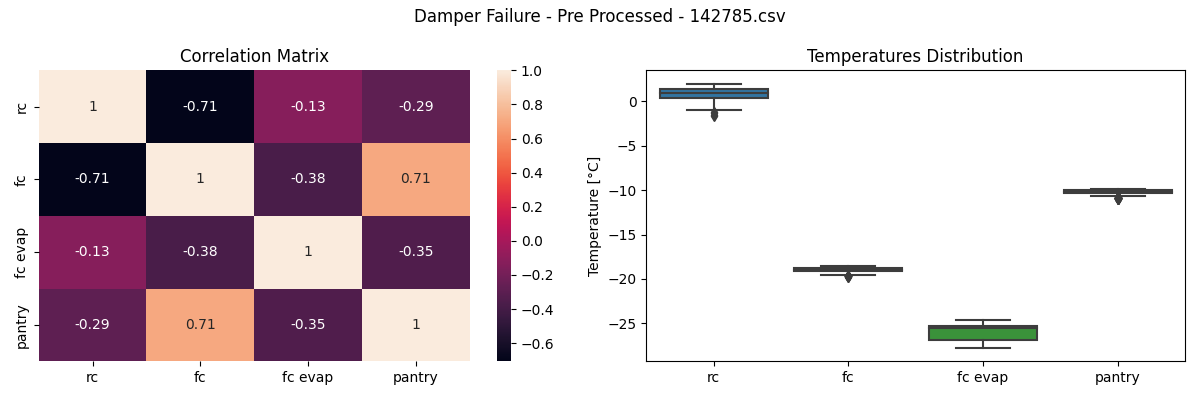

In [5]:
#Pick another know log that contains Pantry damper in failure
damper_failure_log_name = "Pre Processed - 142785.csv"
damper_failure_log_data = csv_files[damper_failure_log_name]
damper_failure_log_data = damper_failure_log_data[:1000] #remove end of the log to avoid defrost state

RefriPlot_PlotTemperature(damper_failure_log_data,"Damper Failure - " + damper_failure_log_name)
RefriPlot_PlotCorrelationAndBoxPlot(damper_failure_log_data,"Damper Failure - " + damper_failure_log_name)

The fault of the damper being stuck OPEN can be assumed since the Pantry Temperature is way below it's usual value, since it should usually be at lowest around -2°C.

But what was also very interesting to observe, and I was not expecting, is that there is a very high correlation between FC and Pantry when we have such failure. Maybe that make sense since the pantry is cycling together with the FC since it's taking cold air from there.

With those two information, which will likely only happen when the damper is stuck open.

Since we're discussing about cycling, it can also be interestin to observe frequency related data from those logs.

***
## 4. Frequency Related Plots

Refrigerators usually cycle around the desired setpoint, and of course those cycles have their own duration, usually referred as period. That leads to indicate that maybe frequency related information could also add information for future machine learning models.

Such information of frequency can be obtained by different means, one of then being the FFT (Fast Fourier Transform):

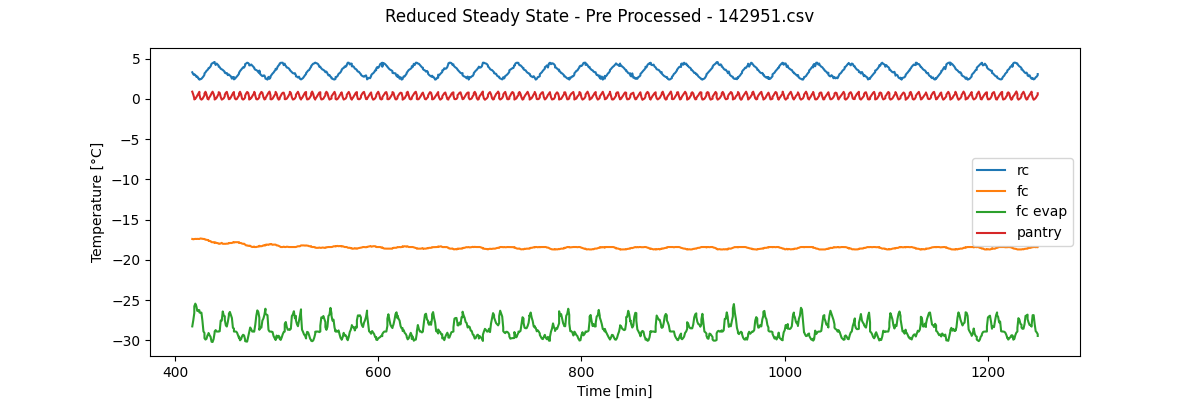

c:\Users\GRANDJ3\Desktop\dev\Diagnostics\AppliedML-Refrigerator_Fault_Detection\venv\Lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\GRANDJ3\Desktop\dev\Diagnostics\AppliedML-Refrigerator_Fault_Detection\venv\Lib\site-packages\matplotlib\text.py:1439: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(y))


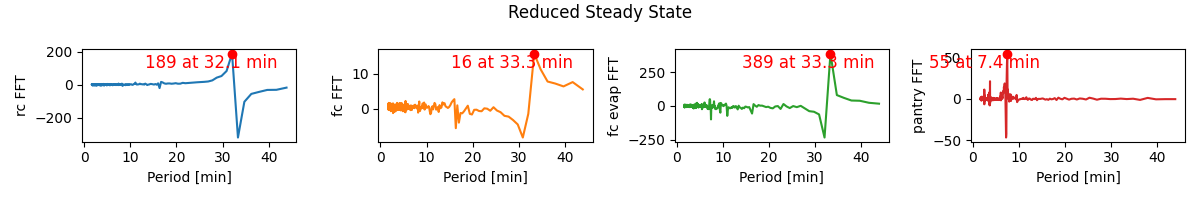

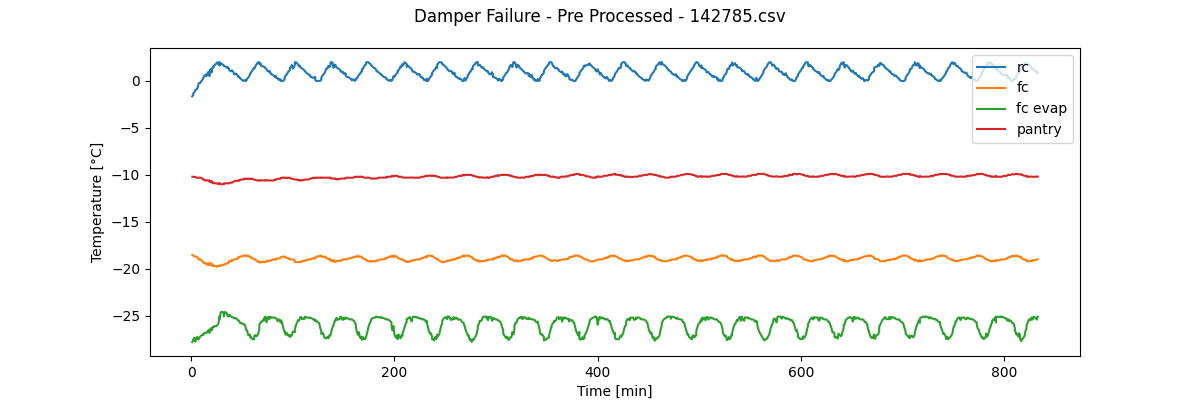

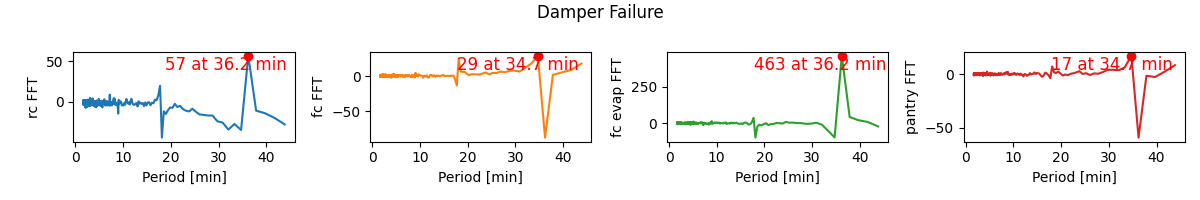

In [6]:
from scipy import signal
from scipy.fft import fft, fftfreq


def get_fft_data(data):
        """
        Get the FFT data for the given input signal.
        
        Parameters:
            data (pandas.Series): The input signal data.
            
        Returns:
            fft_f_filtered (numpy.ndarray): The filtered frequency values in minutes.
            fft_y_filtered (numpy.ndarray): The filtered FFT amplitudes.
        """
        
        SAMPLE_PERIOD = 50                      #According to the preprocessing step, it was observed 50s is the sample time
        fft_y = fft(data.values)
        fft_f = fftfreq(len(data), SAMPLE_PERIOD)           
        
        fft_f = fft_f[1:]; fft_y = fft_y[1:]    #Remove frequency 0 as it's not relevant for our FFT
        fft_f = (1/fft_f)/60                    #Transform frequency to period in minutes to simplify understanding
        
        LOW_PASS_FREQUENCY = 45  # [min]        #Only allow periods smaller than LOW_PASS_FREQUENCY, usually refrigerator cycles are not higher than 45min. Beyond that FFT also loses granularity
        fft_f_filtered = fft_f[(fft_f < LOW_PASS_FREQUENCY) & (fft_f > 0)]
        fft_y_filtered = fft_y[(fft_f < LOW_PASS_FREQUENCY) & (fft_f > 0)]

        return(fft_f_filtered,fft_y_filtered)


def plot_fft_charts(log,title = None):
    """
    Plots the FFT charts of the temperature columns in the log.
            
    Parameters:
        log: Pandas DataFrame containing the temperature logs
        title: (optional) Title for the plot
    """
    
    fig = plt.figure(figsize=(12, 2))
    fig.suptitle(title)
    gs = fig.add_gridspec(1,len(TEMP_COL_NAMES))
    global default_colors

    
    #For each column, plot the FFT of it transformed to period in minutes
    for col_id,column_name in enumerate(TEMP_COL_NAMES):

        fft_f_filtered,fft_y_filtered = get_fft_data(log[column_name])

        #Plot FFT
        ax = fig.add_subplot(gs[0, col_id])
        ax.plot(fft_f_filtered,fft_y_filtered,color=DEFAULT_COLORS[col_id])
        ax.set_ylabel(column_name + ' FFT')
        ax.set_xlabel('Period [min]')

        #Highlight highest frequency on the plot
        max_index = np.argmax(fft_y_filtered)
        ax.plot(fft_f_filtered[max_index], fft_y_filtered[max_index], 'ro')
        ax.annotate(   "{:.0f} at {:.1f} min".format(fft_y_filtered[max_index].real,fft_f_filtered[max_index]), 
                        (round(fft_f_filtered[max_index]), fft_y_filtered[max_index]), textcoords="offset points", xytext=(-15,-10), ha='center', fontsize=12, color='red')

    plt.tight_layout()
    plt.show()


RefriPlot_PlotTemperature(steady_state_log_data[:1000],"Reduced Steady State - " + log_name)
plot_fft_charts(steady_state_log_data[:1000],title="Reduced Steady State") #change steady state log to only get 1000 values so the FFT comparisons can make more sense, since signal size is the same

RefriPlot_PlotTemperature(damper_failure_log_data,"Damper Failure - " + damper_failure_log_name)
plot_fft_charts(damper_failure_log_data,title="Damper Failure")


While the previous temperature charts showed Pantry Damper stuck opened caused high correlation with FC and lower temperatures, the FFT charts show numerically how the pantry does NOT show any high frequency amplitude, numerically indicating that pantry is not cycling.

This means that FFT can have the potential to be one additional information to be used by the machine learning models.

***
## 5. Plotting AutoCorrelation Function

Autocorrelation (sometimes referred as AutoCorrelation Function, or ACF) means correlation of a value with it's own previous value. And of course this very common on time series data, since the Freezer Temperature at certain moment is very likely correlated with it's previous value for example.

For more details on some basic examples of time Series and ACF, please refer to Appendix A.

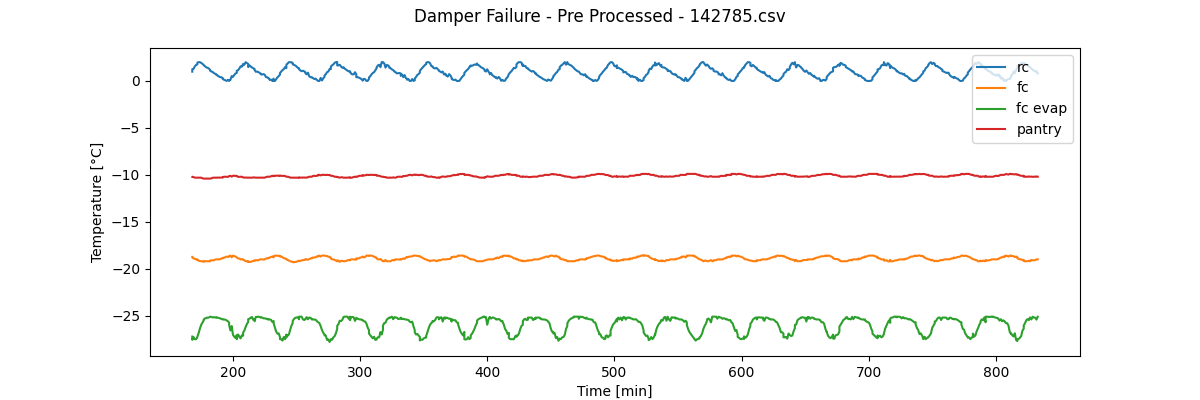

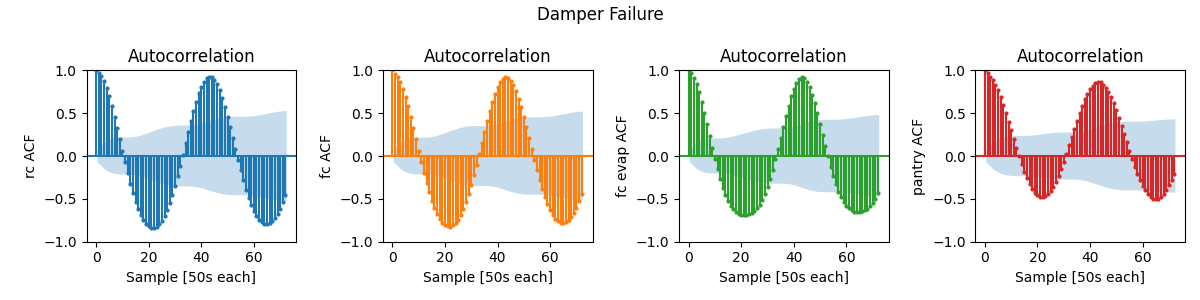

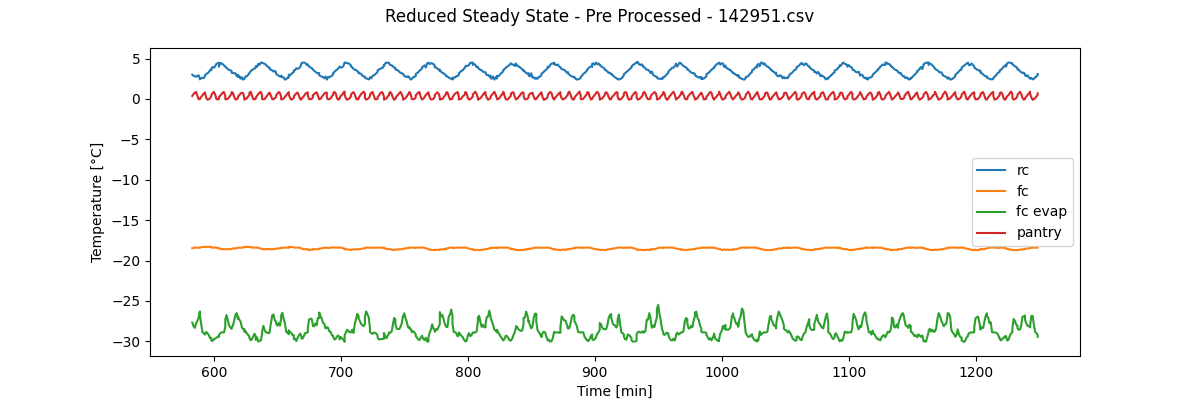

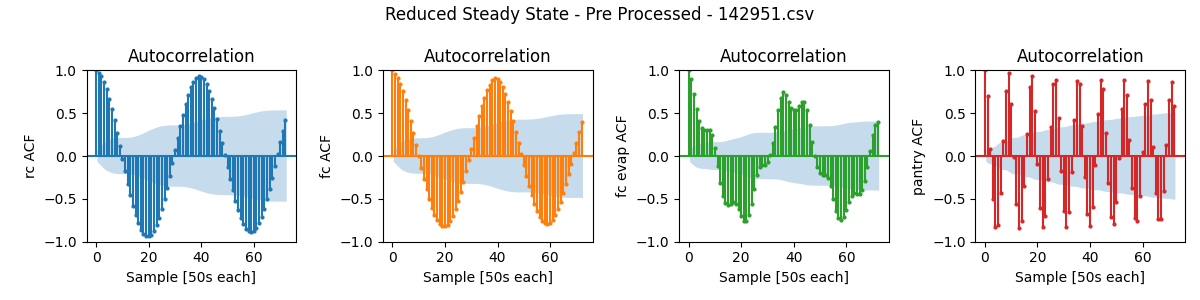

In [7]:
def plot_ACF_charts(log,title = None):
    """
    Plots the ACF charts of the temperature columns in the log.
            
    Parameters:
        log: Pandas DataFrame containing the temperature logs
        title: (optional) Title for the plot
    """
    
    fig = plt.figure(figsize=(12, 3))
    fig.suptitle(title)
    gs = fig.add_gridspec(1,len(TEMP_COL_NAMES))
    global DEFAULT_COLORS

    
    #For each column, plot the ACF
    for col_id,column_name in enumerate(TEMP_COL_NAMES):

        #Plot FFT
        ax = fig.add_subplot(gs[0, col_id])
        plot_acf(log[column_name],lags=72,ax=ax)    #Considering that each lag shall be input as number of samples and each sample is of 50s, using 72 samples which is equal to 60 minutes
        
        #Change color of line and dot of ACF
        for item in ax.collections:
            if type(item) == LineCollection:
                item.set_color(DEFAULT_COLORS[col_id])
        for item in ax.lines:
            item.set_color(DEFAULT_COLORS[col_id])
            item.set_markersize(2)
        
        ax.set_ylabel(column_name + ' ACF')
        ax.set_xlabel('Sample [50s each]')

    plt.tight_layout()
    plt.show()


#Changinge the ranges of the plot to avoid some weird values at start and end of those charts
damper_failure_data_plot = damper_failure_log_data[200:1000]
steady_state_data_plot = steady_state_log_data[200:1000]

RefriPlot_PlotTemperature(damper_failure_data_plot,"Damper Failure - " + damper_failure_log_name)
plot_ACF_charts(damper_failure_data_plot,title="Damper Failure")

RefriPlot_PlotTemperature(steady_state_data_plot,"Reduced Steady State - " + log_name)
plot_ACF_charts(steady_state_data_plot,"Reduced Steady State - " + log_name)


As was observed, when the damper is in failure, the ACF, which is also another proxy for seasonality or frequency analysis, show a very different behavior. The ACF of a damper in failure indicates a similarity more to the ACF of FC Temperature, indicating again that those compartments are cycling in a similar trend

On the steady state log, is also interesting to observe how the FC Evap temperature ACF seems to have a multi seasonal, probably indicating that this signal was generated by multiple signals with different frequencies or different offset, which is probably the case of this log, where the FC and RC are not in synch with one another.

***
## 6. Analyzing complete dataset

Previous analyzes were focused on individual logs to try to understand a little bit more how the correlation and other charactersitics of the data tends to happen. But it's also essential to understand the global view, that means, take all the temperature logs and observe their general behavior

### 6.1 Overall

C:\Users\GRANDJ3\AppData\Local\Temp\ipykernel_11044\2845991690.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12, 4))


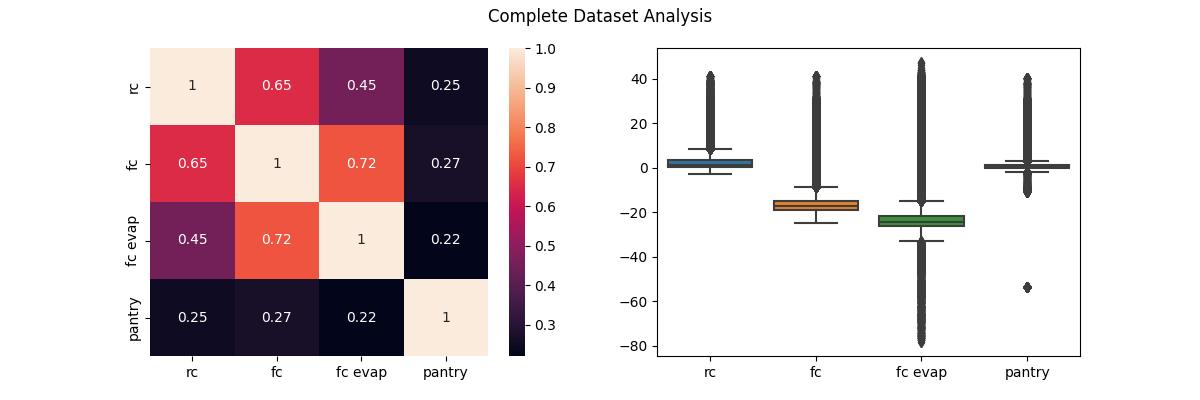

In [8]:
combined_logs_data = pd.concat(csv_files.values(), axis=0)

#Ignore first two columns as they are test time and test time in s then plot their correlation
combined_temperature_logs_data = combined_logs_data.iloc[:, 2:]
corr = combined_temperature_logs_data.corr()

#Plot Correlation Matrix and Box Plot of the complete dataset
fig = plt.figure(figsize=(12, 4))
fig.suptitle("Complete Dataset Analysis")
gs = fig.add_gridspec(1,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

sns.heatmap(corr, annot=True, ax=ax1)
sns.boxplot(data=combined_temperature_logs_data, ax=ax2)
plt.show()

It's now a little bit clearer, some things:

-  **Correlation Matrix**:
    - It shows what was expected, mainly the FC having a high correlation with its evaporator. That makses perfect senses as of course, in all the cases that the FC needs cooling the compressor turns ON, reduces the evap speed which will then reduce the FC temperature. And as the FC is physically closer and in closer temperature range to the FC Evap, it also explains why it has more correlation of FC to FC Evap than RC to FC Evap.
    - The RC shows more correlation to the FC than to the FC Evap. Maybe that also makes sense, because (I think) the RC takes the cold air from FC not straight away from the FC Evap
    - Pantry doesn't show any high correlation, but that maybe also make sense, since it's a very small compartment that gets cool down very fast and is hard to be directly correlated to anything

-  **Distribution Chart**:
    - Of course FC evap with the widest range and many outliers, since it's a very volatile temperature because of the defrost heater. Pantry being a very tightly controlled temperature compartment and some temperature sensors failures observed on the pantry and FC Evap sensors (since temperatures below -50°C are failures)